In [1]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command # using the command we can pass the command from one agent to another agent
from dotenv import load_dotenv
from IPython.display import display, Image
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated # just to mention the metadata
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
load_dotenv()

True

In [3]:
import os

groq_api_key = os.getenv("GROQ_API_KEY")

llm = ChatGroq(groq_api_key=groq_api_key, model_name="deepseek-r1-distill-llama-70b")

llm.invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [4]:
tavily_tool = TavilySearchResults()

In [5]:
tavily_tool.invoke("gdp of india?")

[{'url': 'https://tradingeconomics.com/india/gdp',
  'content': 'The Gross Domestic Product (GDP) in India was worth 3567.55 billion US dollars in 2023, according to official data from the World Bank. The GDP value of India represents 3.38 percent of the world economy. source: World Bank [...] GDP in India averaged 785.41 USD Billion from 1960 until 2023, reaching an all time high of 3567.55 USD Billion in 2023 and a record low of 37.03 USD Billion in 1960. This page provides the latest reported value for - India GDP - plus previous releases, historical high and low, short-term forecast and long-term prediction, economic calendar, survey consensus and news. India GDP - values, historical data and charts - was last updated on May of 2025. [...] GDP in India is expected to reach 3792.00 USD Billion by the end of 2025, according to Trading Economics global macro models and analysts expectations. In the long-term, the India GDP is projected to trend around 4043.00 USD Billion in 2026 and 4

In [6]:
repl = PythonREPL()

In [7]:
code = """ 
x = 5
y = x * 2
print(y)
"""

In [8]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [10]:
@tool 
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
C:\Users\sowmy\AppData\Local\Temp\ipykernel_23096\4134214281.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\sowmy\AppData\Local\Temp\ipykernel_23096\4134214281.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [11]:
def make_system_prompt(instruction: str) -> str:
    return (
        """ You are a helpful AI assistaant, collaboraring with other assistants.
        Use the provided tools to progress towards answering the question.
        If you are unable to fully answer, that's ok, another assistant with different tools 
        will help where you left off. Execute what you can to make progress.
        If you or any of the other assistants have the final answer or deliverable,
        prefix your response with FINAL ANSWER so the team knows to stop.
        \n{instruction}
        """
    )

In [12]:
make_system_prompt(
    "You can only do research. You are working with a chart generator colleague."
)

" You are a helpful AI assistaant, collaboraring with other assistants.\n        Use the provided tools to progress towards answering the question.\n        If you are unable to fully answer, that's ok, another assistant with different tools \n        will help where you left off. Execute what you can to make progress.\n        If you or any of the other assistants have the final answer or deliverable,\n        prefix your response with FINAL ANSWER so the team knows to stop.\n        \n{instruction}\n        "

In [13]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [19]:
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt = make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    )
)

In [22]:
chart_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    )
)

In [23]:
def research_node(state: MessagesState)->Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    
    goto = get_next_node(result['messages'][-1], "chart_generator")
    
    result['messages'][-1] = HumanMessage(content=result['messages'][-1].content, name='researcher')
    
    return Command(update={"messages": result['messages']}, goto=goto)

In [24]:
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    
    goto = get_next_node(result['messages'][-1], "researcher")
    
    result['messages'][-1] = HumanMessage(content=result['messages'][-1].content, name="chart_generator")
    
    return Command(update={"messages": result["messages"]}, goto=goto)

In [25]:
workflow = StateGraph(MessagesState)

workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")

app = workflow.compile()

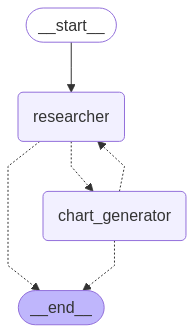

In [26]:
display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
app.invoke({"messages": [("user", "get UK's GDP over the pask 3 years, then make a line chart of it. once you make a chart, finish.")]})

{'messages': [HumanMessage(content="get UK's GDP over the pask 3 years, then make a line chart of it. once you make a chart, finish.", additional_kwargs={}, response_metadata={}, id='c4e1a7b7-96e4-4269-9e57-0fc4f6895087'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_f6nq', 'function': {'arguments': '{"query": "UK GDP past three years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 365, 'prompt_tokens': 285, 'total_tokens': 650, 'completion_time': 1.498909082, 'prompt_time': 0.025062247, 'queue_time': 0.05329389300000001, 'total_time': 1.523971329}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-132fe91b-3dee-4b4e-94bb-3ca5a7b05e2c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP past three years'}, 'id': 'call_f6nq', 'type': 'tool_call'}], usage_metadata={'inp